# Graph-Based Analysis of Neuronal Trees

A [graph](https://en.wikipedia.org/wiki/Graph_theory) is a collection of nodes (or vertices) connected by edges. In the context of neuron morphology analysis, a particularly useful construct is the [rooted tree](https://en.wikipedia.org/wiki/Tree_(graph_theory)#Rooted_tree).
To implement these data structures, we use [`NetworkX`](https://networkx.org/): a Python package for network analysis.
It allows representing neuron morphologies (or collections of morphologies) as graphs, providing a convenient data structure for analysis of various morphological properties including branch lengths, number of terminals, shortest paths, etc.
In this notebook, we will:
- Load neuron reconstruction JSON data into NetworkX graphs
- Plot reconstructions and brain region meshes in 2D and 3D
- Define functions for analyzing and computing morphological properties of the neurons
- Perform dimensionality reduction and clustering uncover patterns in the data 


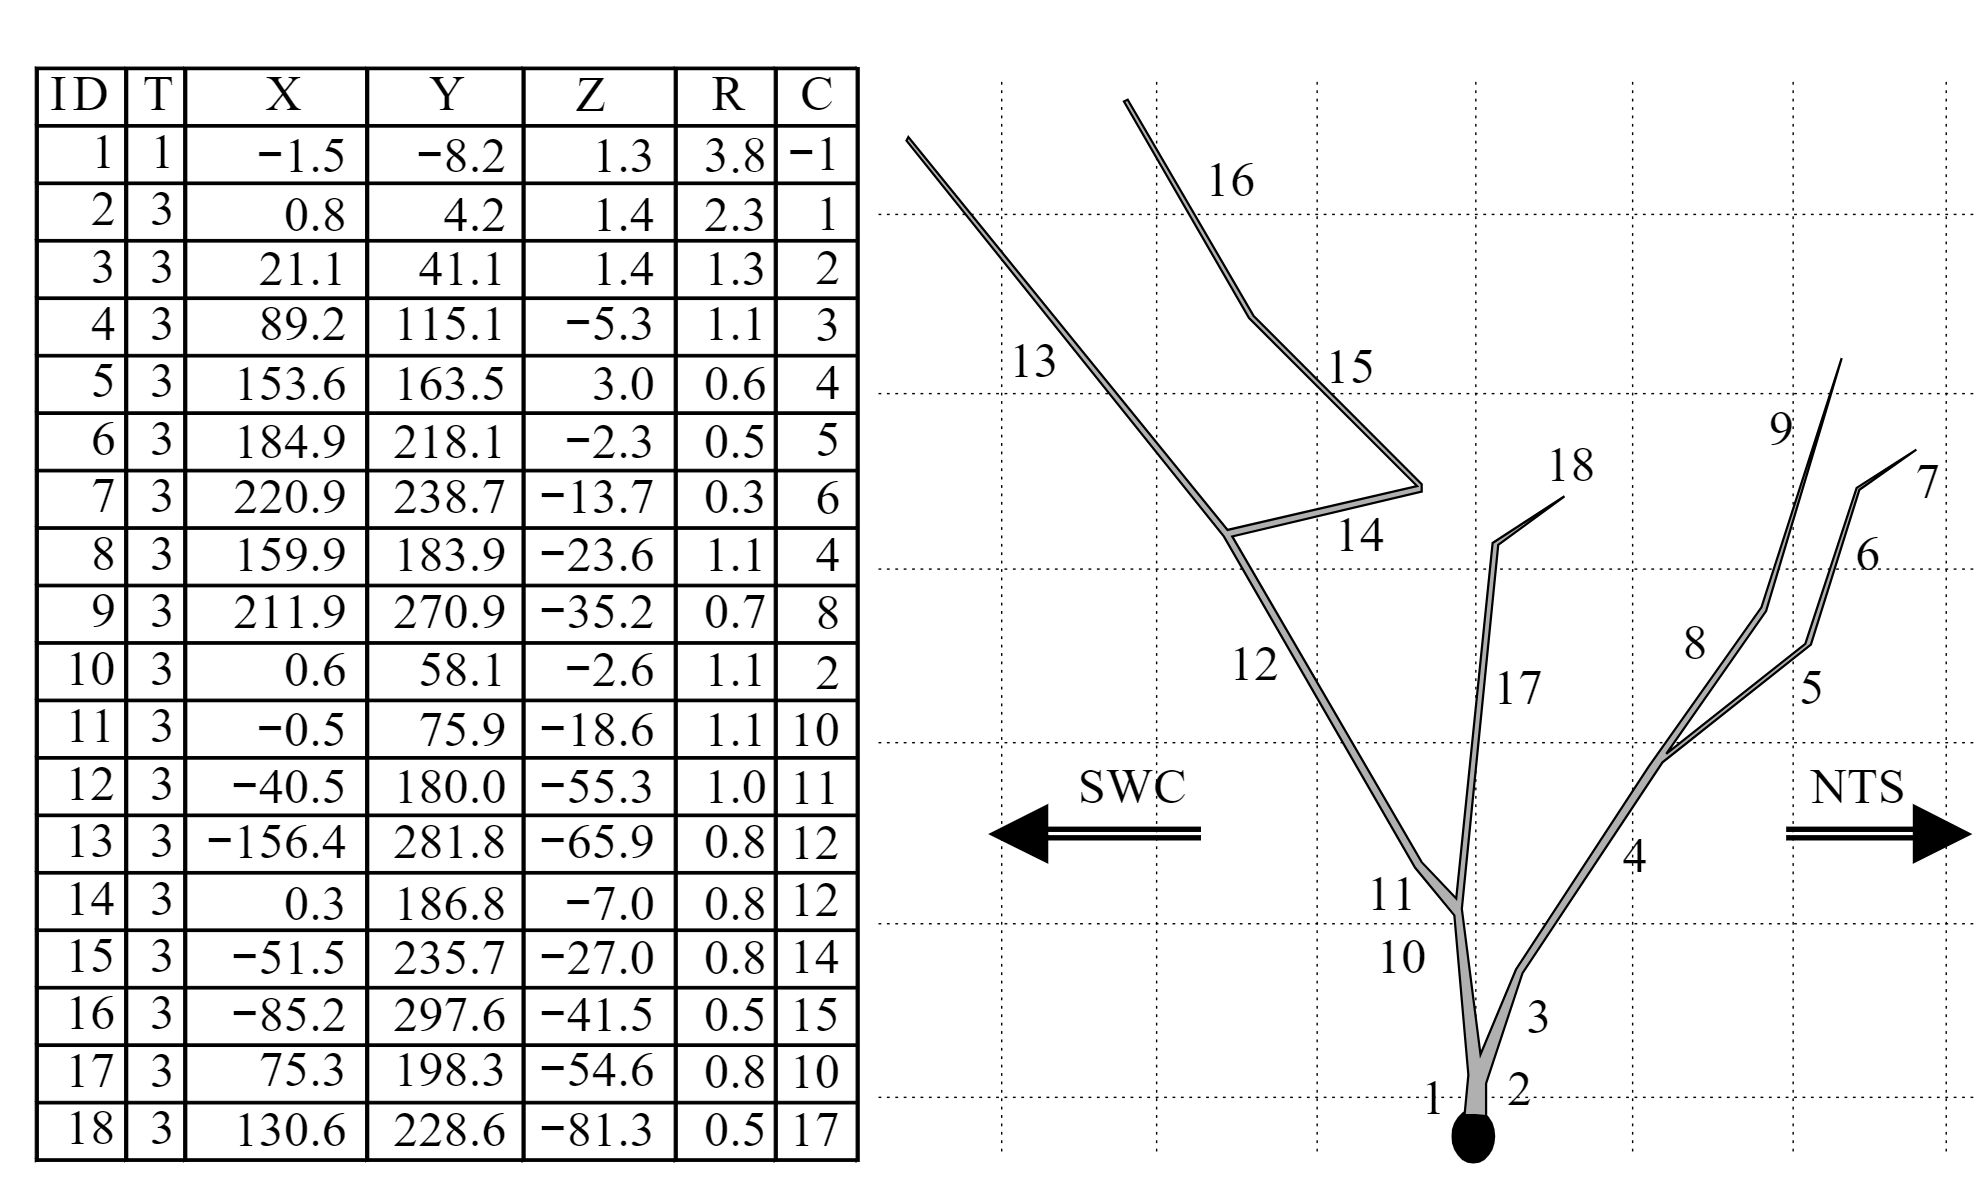
Image from Kötter, R., Ascoli, G. A., Krichmar, J. L., Nasuto, S. J., & Senft, S. L. (2001)

## Loading data into NetworkX

First, we define a function to parse the JSON files that contain the morphology annotation into a graph object. We use a `directed graph` with nodes representing the XYZ coordinates of the annotations and edge weights given by the euclidean distance between adjacent nodes, which allows us to model the cell's 3-dimensional structure.

In [1]:
%matplotlib inline

import os
import json
import random
from multiprocessing import Pool

import k3d
import numpy as np
import networkx as nx
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def euclidean_distance(node1, node2):
    """
    Calculate the Euclidean distance between two nodes.

    Parameters:
    node1, node2 (dict): Nodes with 'pos' key containing x, y, z coordinates.

    Returns:
    float: Euclidean distance between node1 and node2.
    """
    pos1 = np.array(node1['pos'])
    pos2 = np.array(node2['pos'])
    return np.linalg.norm(pos1 - pos2)

def add_node_to_graph(graph, node):
    """
    Add a node with attributes to the graph.

    Parameters:
    graph (nx.DiGraph): The graph to which the node will be added.
    node (dict): Node data.
    """
    graph.add_node(
        node['sampleNumber'], 
        pos=(node['x'], node['y'], node['z']), 
        radius=node['radius'], 
        structure_id=node['structureIdentifier'],
        allen_id=node['allenId']
    )

def add_edge_to_graph(graph, parent, child):
    """
    Add an edge between parent and child nodes in the graph, with weight as Euclidean distance.

    Parameters:
    graph (nx.DiGraph): The graph to which the edge will be added.
    parent, child (int): The sampleNumbers of the parent and child nodes.
    """
    graph.add_edge(
        parent, 
        child, 
        weight=euclidean_distance(
            graph.nodes()[parent],
            graph.nodes()[child]
        )
    )

def json_to_digraph(file_path):
    """
    Load a neuronal reconstruction from a JSON file into a NetworkX graph.

    The JSON file contains SWC data with additional brain region information for each node.
    The graph will be a directed tree.

    Parameters:
    file_path (str): Path to the JSON file containing reconstruction data.

    Returns:
    nx.DiGraph: A directed graph representing the neuronal tree.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
    except IOError as e:
        print(f"Error opening file: {e}")
        return None

    # Certain JSON files may have a single 'neuron' object instead of a 'neurons' array
    neuron_data = data['neuron'] if 'neuron' in data else data['neurons'][0]

    axon_graph, dendrite_graph = nx.DiGraph(), nx.DiGraph()

    for structure, graph in [('dendrite', dendrite_graph), ('axon', axon_graph)]:
        if structure not in neuron_data:
            # Some reconstructions may be missing an axon or dendrite tracing
            print(f"Missing structure {structure} for {file_path}")
            continue
        for node in sorted(neuron_data[structure], key=lambda x: x['sampleNumber']):
            add_node_to_graph(graph, node)
            if node['parentNumber'] != -1:
                add_edge_to_graph(graph, node['parentNumber'], node['sampleNumber'])
                
    if dendrite_graph.nodes() and axon_graph.nodes():
        # Remove duplicate soma node from axon graph
        axon_graph.remove_node(1)  

    # The sampleNumber starts at 1 for both axon and dendrite, so 
    # relabel axon nodes to avoid key collisions when merging the graphs,.
    first_axon_label = max(dendrite_graph.nodes()) + 1 if dendrite_graph.nodes() else 1
    joined_graph = nx.union(
        dendrite_graph, 
        nx.convert_node_labels_to_integers(
            axon_graph, 
            first_label=first_axon_label
        )
    )
    roots = [n for n in joined_graph if joined_graph.in_degree(n) == 0]
    # Link the dendrite to the axon
    if len(roots) == 2:
        add_edge_to_graph(joined_graph, roots[0], roots[1])

    return joined_graph


In [2]:
file_path = "../data/mouselight_reconstructions/AA0001.json"

# Load the neuronal tree into a NetworkX graph
graph = json_to_digraph(file_path)

# Returning a sample of the graph object
print(list(graph.nodes(data=True))[:3])
print(list(graph.edges(data=True))[:3])

# basic validation function, which checks
# if the graph is a directed tree with maximum in-degree equal to 1 (i.e., at most one parent per node).
assert nx.is_arborescence(graph)

[(1, {'pos': (4625.3821881875, 2534.79472175, 2977.33168800001), 'radius': 1, 'structure_id': 1, 'allen_id': 974}), (2, {'pos': (4625.25035225, 2546.07543625, 2966.88777), 'radius': 1, 'structure_id': 3, 'allen_id': 974}), (3, {'pos': (4624.64842425, 2549.12495725, 2963.453114), 'radius': 0.5, 'structure_id': 3, 'allen_id': 974})]
[(1, 2, {'weight': 15.37359175781221}), (1, 77, {'weight': 13.590573234094041}), (1, 113, {'weight': 14.667915976687357})]


In [3]:
list(graph.nodes(data=True))[:5]

[(1,
  {'pos': (4625.3821881875, 2534.79472175, 2977.33168800001),
   'radius': 1,
   'structure_id': 1,
   'allen_id': 974}),
 (2,
  {'pos': (4625.25035225, 2546.07543625, 2966.88777),
   'radius': 1,
   'structure_id': 3,
   'allen_id': 974}),
 (3,
  {'pos': (4624.64842425, 2549.12495725, 2963.453114),
   'radius': 0.5,
   'structure_id': 3,
   'allen_id': 974}),
 (4,
  {'pos': (4624.4793875625, 2557.60549525001, 2956.593848),
   'radius': 0.5,
   'structure_id': 3,
   'allen_id': 974}),
 (5,
  {'pos': (4624.2842500625, 2559.95706225, 2950.89845350001),
   'radius': 0.5,
   'structure_id': 3,
   'allen_id': 974})]

In [4]:
list(graph.edges(data=True))[:5]

[(1, 2, {'weight': 15.37359175781221}),
 (1, 77, {'weight': 13.590573234094041}),
 (1, 113, {'weight': 14.667915976687357}),
 (1, 158, {'weight': 24.978842994125046}),
 (1, 220, {'weight': 28.134476414462327})]


## Extracting Axon and Dendrite Subgraphs

The following cells demonstrate the process of extracting the axon and dendrite sub-trees from the graph. 
The `structure_id` field in the graph is an integer from 0-7, and encodes the type of neuronal compartment. 
The valid types are given by the SWC file specification, which is a standardized format used for representing neuronal reconstructions.

0. undefined
1. soma
2. axon
3. (basal) dendrite
4. apical dendrite
5. fork point
6. end point
7. custom

For more details about the SWC specification, see [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html)

Note that in these reconstructions, no distinction is made between basal and apical dendrite; both have `structure_id == 3`

entifier == 3`.

In [5]:
# Define a function for filtering the graph based on attribute values
def get_subgraph(G, attribute, values):
    """
    Extract a subgraph from the given graph based on specified attribute values.

    Parameters:
    G (nx.Graph): The original graph from which to extract the subgraph.
    attribute (str): The node attribute used for filtering.
    values (tuple): A tuple of attribute values to include in the subgraph.

    Returns:
    nx.Graph: A subgraph of G containing only nodes with the specified attribute values.
    """
    filtered_nodes = [node for node, attr in G.nodes(data=True) if attr.get(attribute) in values]
    return G.subgraph(filtered_nodes)

# Extract the axon and dendrite subgraphs
# We include the soma node in the dendrite subgraph to maintain connectivity, 
# since it is the central point from which dendritic branches originate.
attribute = "structure_id"
axon = get_subgraph(graph, attribute, (2,))
dendrite = get_subgraph(graph, attribute, (1, 3))

# Check if the resulting subgraphs are trees
print("Is Axon a Tree:", nx.is_arborescence(axon))
print("Is Dendrite a Tree:", nx.is_arborescence(dendrite))

Is Axon a Tree: True
Is Dendrite a Tree: True


## Basic 2D plotting

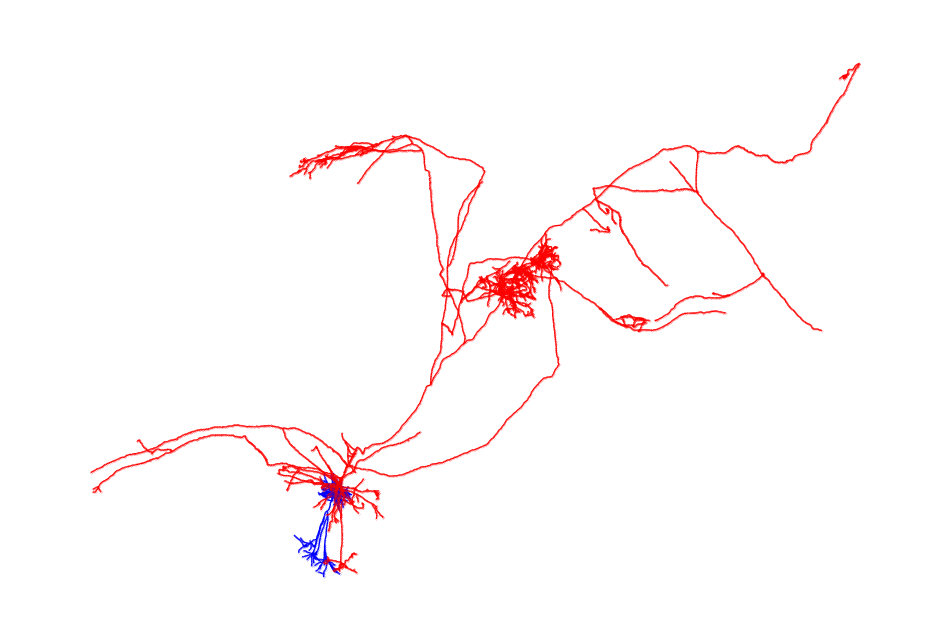

In [6]:
def plot_graph_2d(graph, ax, color="blue", node_size=0.01, width=1):
    """
    Generate a 2D plot of a neuronal tree graph using matplotlib.

    Parameters:
    graph (nx.DiGraph): A directed graph representing the neuronal tree.
    """
    # Extracting node positions
    pos = {node: data['pos'][:2] for node, data in graph.nodes(data=True)}

    nx.draw(
        graph, 
        pos,
        ax=ax,
        arrows=False,
        width=width,
        with_labels=False, 
        node_size=node_size, 
        node_color=color,
        edge_color=color
    )
    
    
fig, ax = plt.subplots(figsize=(12, 8))

plot_graph_2d(dendrite, ax, "blue")
plot_graph_2d(axon, ax, "red")

plt.show()

### Morphological Analysis

We aim to quantify various morphological features to understand the diverse shapes of different neurons better. To achieve this, we will implement functions to calculate several key features:

- **Branch Points** (list): Nodes with more than one child.
- **Terminals** (list): Nodes with no children.
- **Roots** (list): Nodes with no parent.
- **Total Length** (float): The sum of all edge weights in the graph, representing the approximate total cable length of the neuron in micrometers.
- **Bounding Box** (tuple): The corner points of the 3D bounding box encompassing all graph nodes, providing a simple representation of the spatial extent and overall shape of the neuron.
- **Depth** (float): The Z extent of the bounding box.
- **Width** (float): The X extent of the bounding box.
- **Height** (float): The Y extent of the bounding box.
- **Centroid** (tuple): The XYZ coordinates of the bounding box centroid.


In [7]:
def find_branch_points(graph):
    """
    Identify all branch points in a graph. A branch point is defined as a node with more than one child.

    Parameters:
    graph (nx.Graph): The graph to analyze.

    Returns:
    list: A list of nodes that are branch points.
    """
    branch_points = [node for node in graph.nodes() if graph.out_degree(node) > 1]
    return branch_points

def find_terminals(graph):
    """
    Find all terminal nodes in a graph. A terminal node is defined as a node with no children.

    Parameters:
    graph (nx.Graph): The graph to analyze.

    Returns:
    list: A list of nodes that are terminal nodes.
    """
    terminal_nodes = [node for node in graph.nodes() if graph.out_degree(node) == 0]
    return terminal_nodes

def find_roots(graph):
    """
    Find the root nodes of a graph. A root node is defined as a node with no parent.

    Parameters:
    graph (nx.Graph): The graph to analyze.

    Returns:
    list: A list of root nodes.
    """
    roots = [node for node in graph.nodes() if graph.in_degree(node) == 0]
    return roots

def total_length(graph):
    """
    Calculate the total length of all edges in the graph.

    Parameters:
    graph (nx.Graph): The graph with weighted edges.

    Returns:
    float: Total length of all edges in the graph.
    """
    total_length = sum(weight for _, _, weight in graph.edges.data("weight"))
    return total_length

def bounding_box(graph):
    """
    Compute the bounding box of the XYZ coordinates of the graph nodes.

    Parameters:
    graph (nx.Graph): The graph with nodes containing XYZ coordinates.

    Returns:
    tuple: A tuple containing two tuples - the minimum and maximum XYZ coordinates.
           Format: ((min_x, min_y, min_z), (max_x, max_y, max_z))
    """
    # Initialize min and max coordinates with the first node's coordinates
    first_node = list(graph.nodes(data=True))[0][1]
    min_x, min_y, min_z = first_node['pos']
    max_x, max_y, max_z = first_node['pos']

    for _, attr in graph.nodes(data=True):
        x, y, z = attr['pos']
        min_x, min_y, min_z = min(min_x, x), min(min_y, y), min(min_z, z)
        max_x, max_y, max_z = max(max_x, x), max(max_y, y), max(max_z, z)

    return ((min_x, min_y, min_z), (max_x, max_y, max_z))

def get_depth(bounding_box):
    """
    Calculate the depth of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    float: Depth of the graph.
    """
    min_z, max_z = bounding_box[0][2], bounding_box[1][2]
    return max_z - min_z

def get_height(bounding_box):
    """
    Calculate the height of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    float: Height of the graph.
    """
    min_y, max_y = bounding_box[0][1], bounding_box[1][1]
    return max_y - min_y

def get_width(bounding_box):
    """
    Calculate the width of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    float: Width of the graph.
    """
    min_x, max_x = bounding_box[0][0], bounding_box[1][0]
    return max_x - min_x


def get_centroid(bounding_box):
    """
    Calculate the centroid of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    tuple: The centroid (x, y, z) of the graph.
    """
    min_coords, max_coords = bounding_box
    centroid = tuple((min_coords[i] + max_coords[i]) / 2 for i in range(3))
    return centroid


In [8]:
branch_points = find_branch_points(axon)
terminals = find_terminals(axon)
roots = find_roots(axon)
length = total_length(axon)

# Display the results
print("Axon Branch Points:", len(branch_points))
print("Axon Terminal Nodes:", len(terminals))
print("Axon Root:", len(roots))
print(f"Total Axon length: {length:.2f}um")

bbox = bounding_box(graph)
print(f"Bounding box dimensions: {bbox}")
print(f"Bounding box depth: {get_depth(bbox)}")
print(f"Bounding box width: {get_width(bbox)}")
print(f"Bounding box height: {get_height(bbox)}")
print(f"Bounding box centroid: {get_centroid(bbox)}")

Axon Branch Points: 382
Axon Terminal Nodes: 392
Axon Root: 1
Total Axon length: 98386.60um
Bounding box dimensions: ((2414.687321375, 1742.6953605, 1275.10017600001), (9319.1928203125, 6469.099084, 6266.113178))
Bounding box depth: 4991.01300199999
Bounding box width: 6904.5054989375
Bounding box height: 4726.4037235000005
Bounding box centroid: (5866.940070843751, 4105.897222250001, 3770.6066770000048)


## Finding inter-branch segments

Now let's try something a bit more interesting. We can decompose the tree into a collection of branches, where a "branch" satisfies one of the following conditions:
1) Start at root -> End at (branch point or terminal)
3) Start at branch point -> End at (branch point or terminal)

For clarity, we will plot an example of this below.

Then, we plot a histogram of branch lengths.

In [9]:
import matplotlib.colors as mcolors

def get_branches(graph):
    """
    Extract branches from the graph by tracing paths backwards from branch points and terminal nodes.

    Parameters:
    graph (nx.Graph): The graph from which to extract branches.

    Returns:
    list: A list of branches, where each branch is a list of tuples (u, v, edge_data).
          Each tuple represents an edge in the branch.
    """
    # Find all branch points and terminals
    relevant_nodes = find_branch_points(graph) + find_terminals(graph)

    branches = []
    for node in relevant_nodes:
        # Skip root nodes as they don't lead to a previous relevant node
        if graph.in_degree(node) == 0:
            continue

        path = []
        current = node
        # Walk back to the previous relevant node or root
        while graph.in_degree(current) > 0:
            parent = next(graph.predecessors(current))
            edge_data = graph.get_edge_data(parent, current)
            path.insert(0, (parent, current, edge_data))
            
            # Break the loop if a new branch point is reached
            if graph.out_degree(parent) > 1:
                break
            current = parent

        branches.append(path)

    return branches


def calculate_branch_length(branch):
    """
    Calculate the total length of a branch using the edge weights.

    Parameters:
    branch (list of tuples): Each tuple is an edge represented as (u, v, edge_data),
                             where edge_data is a dictionary containing the edge's weight.

    Returns:
    float: The total length of the branch.
    """
    total_length = 0.0
    for _, _, edge_data in branch:
        total_length += edge_data.get('weight', 0.0)  # Add the edge's weight, defaulting to 0 if not present

    return total_length

def plot_graph_branches(graph, branches):
    """
    Plots the branches of the graph in random colors using the 'pos' attribute of nodes for positioning.

    Parameters:
    graph (nx.Graph): The graph from which to plot the branches.
    """

    # Set up the plot
    plt.figure(figsize=(10, 10))

    # Retrieve positions from the 'pos' attribute of the nodes
    pos = {node: graph.nodes[node]['pos'][:2] for node in graph.nodes}

    # Generate random colors for each branch
    colors = [ "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
               for _ in range(len(branches)) ]

    for branch, color in zip(branches, colors):
        # Extract nodes and edges from each branch
        branch_nodes = {u for u, v, d in branch} | {v for u, v, d in branch}
        branch_edges = [(u, v) for u, v, d in branch]

        # Draw nodes and edges for each branch
        nx.draw_networkx_nodes(graph, pos, nodelist=branch_nodes, node_color=[color], node_size=0.01)
        nx.draw_networkx_edges(graph, pos, edgelist=branch_edges, arrows=False, width=1, edge_color=[color])

    plt.axis('off')
    plt.show()




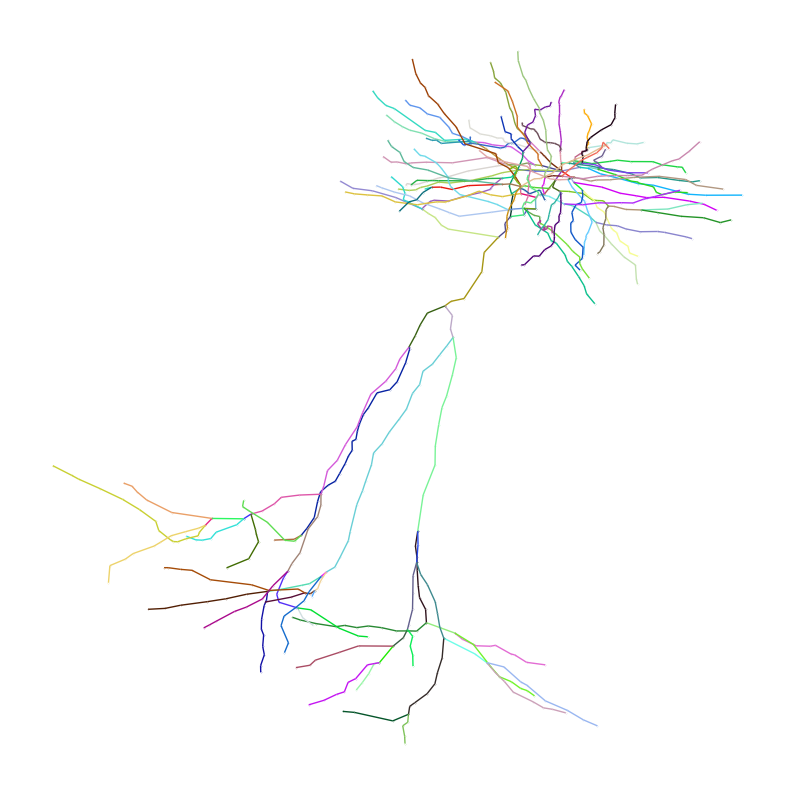

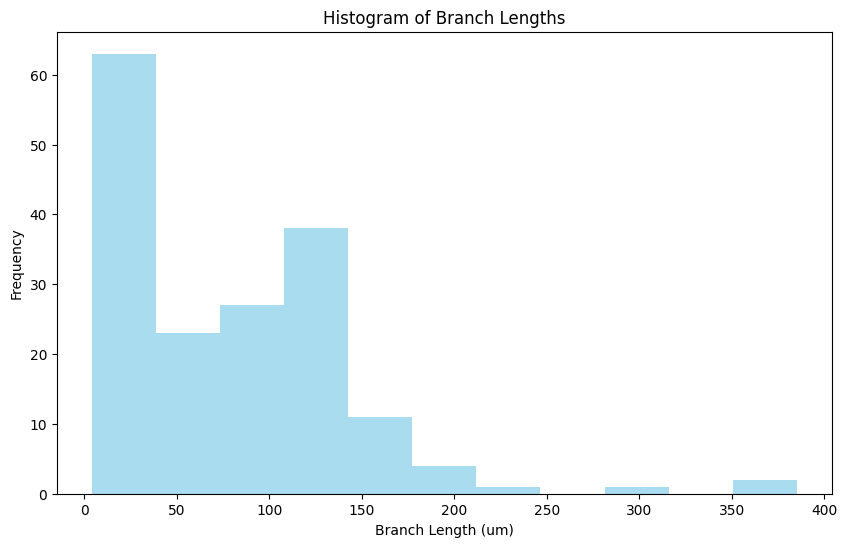

In [10]:
plot_graph_branches(dendrite, get_branches(dendrite))

branches = get_branches(dendrite)
branch_lengths = [calculate_branch_length(branch) for branch in branches]

plt.figure(figsize=(10, 6))
plt.hist(branch_lengths, bins='auto', color='skyblue', alpha=0.7)
plt.title("Histogram of Branch Lengths")
plt.xlabel("Branch Length (um)")
plt.ylabel("Frequency")
plt.show()

## Computing the longest-shortest path

Let's find the [longest-shortest path](https://en.wikipedia.org/wiki/Longest_path_problem) in the graph.
NetworkX has a large suite of functions for computing shortest paths between vertices.
Since our graph is a DAG (directed acyclic graph, of which a tree is a special case), we can use `nx.dag_longest_path`, which runs in linear time.

In [11]:
def get_longest_path(graph):
    longest_path = nx.dag_longest_path(graph, weight='weight')
    longest_path_edges = zip(longest_path, longest_path[1:])
    return longest_path, sum(graph.get_edge_data(*e)['weight'] for e in longest_path_edges)

longest_path, longest_path_len = get_longest_path(graph)
print("longest path from root to any terminal:", longest_path_len, "um") 

longest path from root to any terminal: 9771.961532068239 um


In [12]:
def plot_path_overlay(graph, path, path_color='red', graph_color='blue'):
    """
    Plot the graph with the longest path highlighted in a different color.

    Parameters:
    graph (nx.Graph): The graph to be visualized.
    path_color (str): Color for the longest path. Default is 'red'.
    graph_color (str): Color for the rest of the graph. Default is 'blue'.
    """

    path_edges = set(zip(path, path[1:]))

    # Draw the graph
    pos = {node: data['pos'][:2] for node, data in graph.nodes(data=True)}
    nx.draw(graph, pos, arrows=False, width=1, node_size=1, with_labels=False, node_color=graph_color, edge_color=graph_color)

    # Draw the longest path on top of the graph
    path_edge_colors = [path_color if (u, v) in path_edges or (v, u) in path_edges else graph_color for u, v in graph.edges()]
    nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color=path_color, node_size=1)
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color=path_color, width=1, arrows=False)

    plt.show()


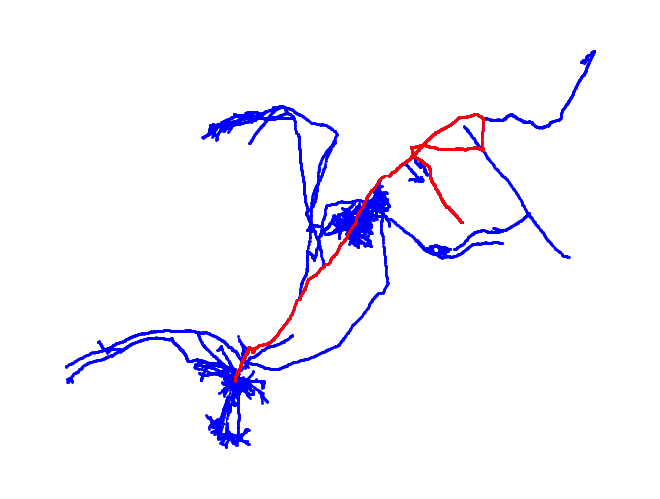

In [13]:
plot_path_overlay(graph, longest_path)

## Tracing the brain regions taken by the longest path

In [14]:
import pandas as pd

# Load the CCF structure data as a DataFrame
ccf_structures = pd.read_csv('/data/allen_mouse_ccf/annotation/adult_mouse_ccf_structures.csv')
ccf_structures.head()

,id,name,acronym,hemisphere_id,parent_structure_id,graph_order,structure_id_path,color_hex_triplet
0,1000,extrapyramidal fiber systems,eps,3,1009.0,1218,/997/1009/1000/,CCCCCC
1,223,Arcuate hypothalamic nucleus,ARH,3,157.0,733,/997/8/343/1129/1097/157/223/,FF5D50
2,12998,"Somatosensory areas, layer 6b",SS6b,3,453.0,36,/997/8/567/688/695/315/453/12998/,188064
3,163,"Agranular insular area, posterior part, layer 2/3",AIp2/3,3,111.0,287,/997/8/567/688/695/315/95/111/163/,219866
4,552,"Pontine reticular nucleus, ventral part",PRNv,3,987.0,914,/997/8/343/1065/771/987/552/,FFBA86


In [15]:
# Create a dictionary mapping region acronym to allen ID, since
# it is easier to remember acronyms like 'MOs5'

acronym_to_id = ccf_structures.set_index('acronym')['id'].to_dict()
# Show the first 5 key-value pairs
list(acronym_to_id.items())[:5]

[('eps', 1000), ('ARH', 223), ('SS6b', 12998), ('AIp2/3', 163), ('PRNv', 552)]

In [16]:
def get_adjusted_region_id(allen_id, ccf_structures, max_ccf_depth):
    """
    Get the adjusted region ID based on the maximum desired CCF depth.

    In some analyses, it may be desirable to limit the granularity of the structure analysis to a certain
    level in the hierarchy. For instance, higher levels (lower depths) correspond to more general
    categories (like 'Cortex'), while lower levels (greater depths) correspond to more specific regions
    (like 'Secondary Motor Area, Layer 5'). Limiting the depth can simplify the analysis by focusing on broader regions
    and avoiding overly detailed subdivisions.

    Parameters:
    allen_id (int): The ID of the structure in the Allen Brain Atlas.
    ccf_structures (DataFrame): A DataFrame containing the mapping of structures to their respective
                                IDs and hierarchical paths in the CCF.
    max_ccf_depth (int): The maximum depth in the CCF hierarchy to consider for the adjustment.

    Returns:
    int: The adjusted region ID if the depth of the structure exceeds the max_ccf_depth, otherwise
         returns the original allen_id.
    """
    if allen_id is None:
        return None
    struct_path = ccf_structures[ccf_structures.id == allen_id].structure_id_path.values[0]
    struct_path = struct_path.strip('/').split('/')
    ccf_depth = len(struct_path) - 1
    if ccf_depth > max_ccf_depth:
        adjustment = max_ccf_depth - ccf_depth
        return int(struct_path[adjustment])
    return allen_id


def trace_longest_path_regions(longest_path, graph, ccf_structures, max_ccf_depth=7):
    """
    Trace the regions along the longest path in a graph, considering the CCF hierarchy.

    Parameters:
    longest_path (list): The longest path in the graph as a list of nodes.
    graph (nx.Graph): The graph representing the neuronal tree.
    ccf_structures (DataFrame): DataFrame containing CCF structure information.
    max_ccf_depth (int): Maximum depth in the CCF hierarchy to consider for regions.

    Returns:
    list: A list of unique region acronyms along the longest path without adjacent duplicates.
    """

    def remove_adjacent_duplicates(seq):
        """Remove adjacent duplicates from a sequence."""
        result = []
        prev = None
        for item in seq:
            if item != prev:
                result.append(item)
                prev = item
        return result

    # Construct the sequence of region acronyms along the longest path
    region_seq = []
    for node in longest_path:
        node_data = graph.nodes().data()[node]
        allen_id = node_data['allen_id']
        adjusted_id = get_adjusted_region_id(allen_id, ccf_structures, max_ccf_depth)
        acronym = ccf_structures[ccf_structures.id == adjusted_id].acronym.values[0]
        region_seq.append(acronym)

    # Remove adjacent duplicates and return the result
    return remove_adjacent_duplicates(region_seq)


In [17]:
print(" -> ".join(
    trace_longest_path_regions(
        longest_path, 
        graph, 
        ccf_structures,
        max_ccf_depth=6
    )
))

SSp -> MOp -> SSp -> MOp -> scwm -> ccb -> CP -> GPe -> PAL -> int -> GPi -> int -> cpd -> SNr -> MB -> HY -> ZI -> HY -> VM -> HY -> VM -> HY -> VM -> mtt -> SMT -> VM -> SMT -> VM -> TH -> RE -> TH -> RE -> TH -> VP


## Dimensionality Reduction and Clustering

Let's use these metrics to perform dimensionality reduction (PCA, UMAP) and clustering (HDBSCAN) to explore underlying structure in the data.
We will try to cluster neurons from Secondary Motor Area, Layer 5 using morphological features.
First let's define functions for loading neuron graphs from specific CCF regions

In [18]:
def load_graphs(filepaths):
    """
    Load all JSON files in the given directory as graphs using multiprocessing.

    Parameters:
    directory_path (str): Path to the directory containing JSON files.

    Returns:
    list of nx.Graph: A list of graphs loaded from the JSON files.
    """
    # Use multiprocessing pool to load graphs in parallel
    with Pool() as pool:
        graphs = list(tqdm(pool.imap(json_to_digraph, filepaths), total=len(filepaths)))

    # Remove None values from the list in case there were errors
    return [graph for graph in graphs if graph is not None]


def get_cells_in_regions(manifest_path, acronyms):
    # Load the CSV file
    df = pd.read_csv(manifest_path)

    # If a single acronym is provided, convert it to a list
    if isinstance(acronyms, str):
        acronyms = [acronyms]

    # Filter the dataframe for the specified acronyms and get the filenames
    filtered_df = df[df['soma_acronym'].isin(acronyms)]
    filenames = filtered_df['filename'].tolist()
    filtered_acronyms = filtered_df['soma_acronym'].tolist()

    return filenames, filtered_acronyms

In [19]:
manifest_path = "../scratch/reconstructed_neurons.csv"
paths, acronyms = get_cells_in_regions(manifest_path, ['MOs5'])
graphs = load_graphs(paths)

100%|██████████| 163/163 [00:18<00:00,  8.71it/s]


Now we define functions to load data from [Wavefront OBJ](https://en.wikipedia.org/wiki/Wavefront_.obj_file) files, which is one format used to represent CCF structure meshes
This will let us plot the 3D structures of different brain regions along with the reconstructions.

In [20]:
def load_obj(filename):
    """
    Load the vertices, vertex normals, and indices from a .obj file.

    Parameters:
    filename (str): Path to the .obj file

    Returns:
    tuple: A tuple containing three elements:
        - vertices (list of tuples): List of vertices, each vertex is a tuple (x, y, z)
        - normals (list of tuples): List of vertex normals, each normal is a tuple (nx, ny, nz)
        - indices (list of tuples): List of indices, each index is a tuple of vertex indices defining a face
    """
    vertices = []
    normals = []
    indices = []

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex definition
                parts = line.split()
                vertices.append((float(parts[1]), float(parts[2]), float(parts[3])))
            elif line.startswith('vn '):  # Vertex normal definition
                parts = line.split()
                normals.append((float(parts[1]), float(parts[2]), float(parts[3])))
            elif line.startswith('f '):  # Face definition
                parts = line.split()
                # Extracting only the vertex indices (ignoring texture and normal indices)
                face_indices = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                indices.append(tuple(face_indices))

    return vertices, normals, indices


def get_mesh_from_id(allen_id):
    obj_dir = "../data/ccf_2017_obj"
    obj_path = os.path.join(obj_dir, f"{allen_id}.obj")
    return load_obj(obj_path)


For more sophisticated 3D plotting, we can use the [k3d](https://github.com/K3D-tools/K3D-jupyter) library, which enables interactive plotting of meshes and skeletons

In [21]:
def rgb_to_hex(r,g,b):
    # Convert to a hexadecimal string
    hex_color = f'{r:02x}{g:02x}{b:02x}'
    # Convert the hexadecimal string to an integer in base-16
    color_int = int(hex_color, 16)
    return color_int

def random_color_hex():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return rgb_to_hex(red, green, blue)

def graph_to_lines(g):
    # Extract vertex positions
    g_verts = np.array([g.nodes[n]['pos'] for n in sorted(g.nodes())], dtype=np.float32)
    # Pairs of indices into the vertex array are edges
    # Node keys start at 1, so offset by -1 to get indices
    g_inds = np.array([[u-1, v-1] for u, v in g.edges()], dtype=np.float32)
    g_lines = k3d.factory.lines(g_verts, g_inds, indices_type='segment', color=random_color_hex(), width=1, shader='simple')
    return g_lines

def plot_graphs(graphs, plot):
    for i, g in enumerate(graphs):
        g_lines = graph_to_lines(g)
        plot += g_lines

def plot_ccf_mesh(allen_id, plot, color=0x4d3d3d, opacity=0.1):
    vertices, normals, indices = get_mesh_from_id(allen_id)
    
    plt_tetra = k3d.mesh(
        vertices, 
        indices, 
        normals=normals,
        color=color,
        wireframe=False,
        opacity=opacity
    )

    plot += plt_tetra

Let's plot a random subset of neurons from MOs5 to see if we can identify any obvious morphological patterns

In [22]:
random.seed(47)

plot = k3d.plot()
plot_graphs(random.sample(graphs, 10), plot)
plot_ccf_mesh(acronym_to_id['root'], plot, color=rgb_to_hex(128,128,128), opacity=0.05)
plot_ccf_mesh(acronym_to_id['MOs5'], plot, color=rgb_to_hex(0, 255, 0), opacity=0.05)
plot.display()

Output()

Using the intuition gained from looking at the 3D structure of the neurons, think about what kinds of metrics could be used to differentiate cell groups based on their morphological properties.
For simplicity, let's use the metrics we have defined earlier, and extract them into an `m x n` array, where `m == num neurons` and `n == num features`

In [23]:
def get_metrics(graph):
    metrics = {
        'num_branch_points': len(find_branch_points(graph)),
        'num_terminals': len(find_terminals(graph)),
        'total_length': total_length(graph)
    }

    branch_lengths = np.array([calculate_branch_length(branch) for branch in get_branches(graph)])
    metrics.update({
        'mean_branch_length': branch_lengths.mean(),
        'std_branch_length': branch_lengths.std(),
        'max_branch_length': branch_lengths.max()
    })
    
    metrics['longest_path_length'] = get_longest_path(graph)[1] # just the length

    bbox = bounding_box(graph)
    metrics.update({
        'depth': get_depth(bbox),
        'width': get_width(bbox),
        'height': get_height(bbox)
    })

    centroid = get_centroid(bbox)
    metrics.update({
        'centroid_x': centroid[0],
        'centroid_y': centroid[1],
        'centroid_z': centroid[2]
    })

    return metrics

def all_graph_metrics(graphs):
    all_metrics = []
    for graph in tqdm(graphs):
        metrics = get_metrics(graph)
        all_metrics.append(metrics)
    df = pd.DataFrame(all_metrics)
    return df

In [24]:
X = all_graph_metrics(graphs)

100%|██████████| 163/163 [00:13<00:00, 11.71it/s]


In [25]:
print(X)

     num_branch_points  num_terminals   total_length  mean_branch_length  \
0                  179            180   97363.793666          271.965904   
1                  371            381   92080.335643          122.610300   
2                  392            394  171392.923314          218.057154   
3                   99            108   57824.578432          280.701837   
4                  279            287   56859.558347          100.636386   
..                 ...            ...            ...                 ...   
158                322            329   45738.717191           70.367257   
159                645            655  460744.080939          354.691363   
160                259            266   43251.456852           82.540948   
161                257            264  105782.825097          203.428510   
162                191            199   87747.785675          225.572714   

     std_branch_length  max_branch_length  longest_path_length         depth  \
0      

## Correlation Matrix and Pair Plot to visualize relationships between features

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

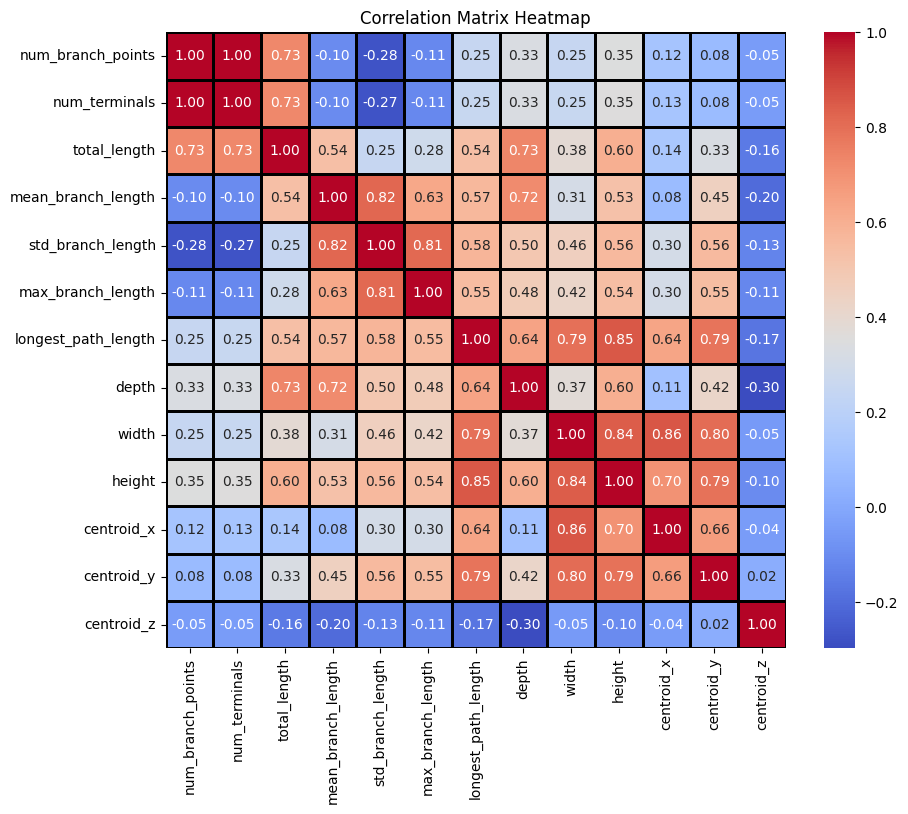

In [26]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2, linecolor='black')
plt.title('Correlation Matrix Heatmap')

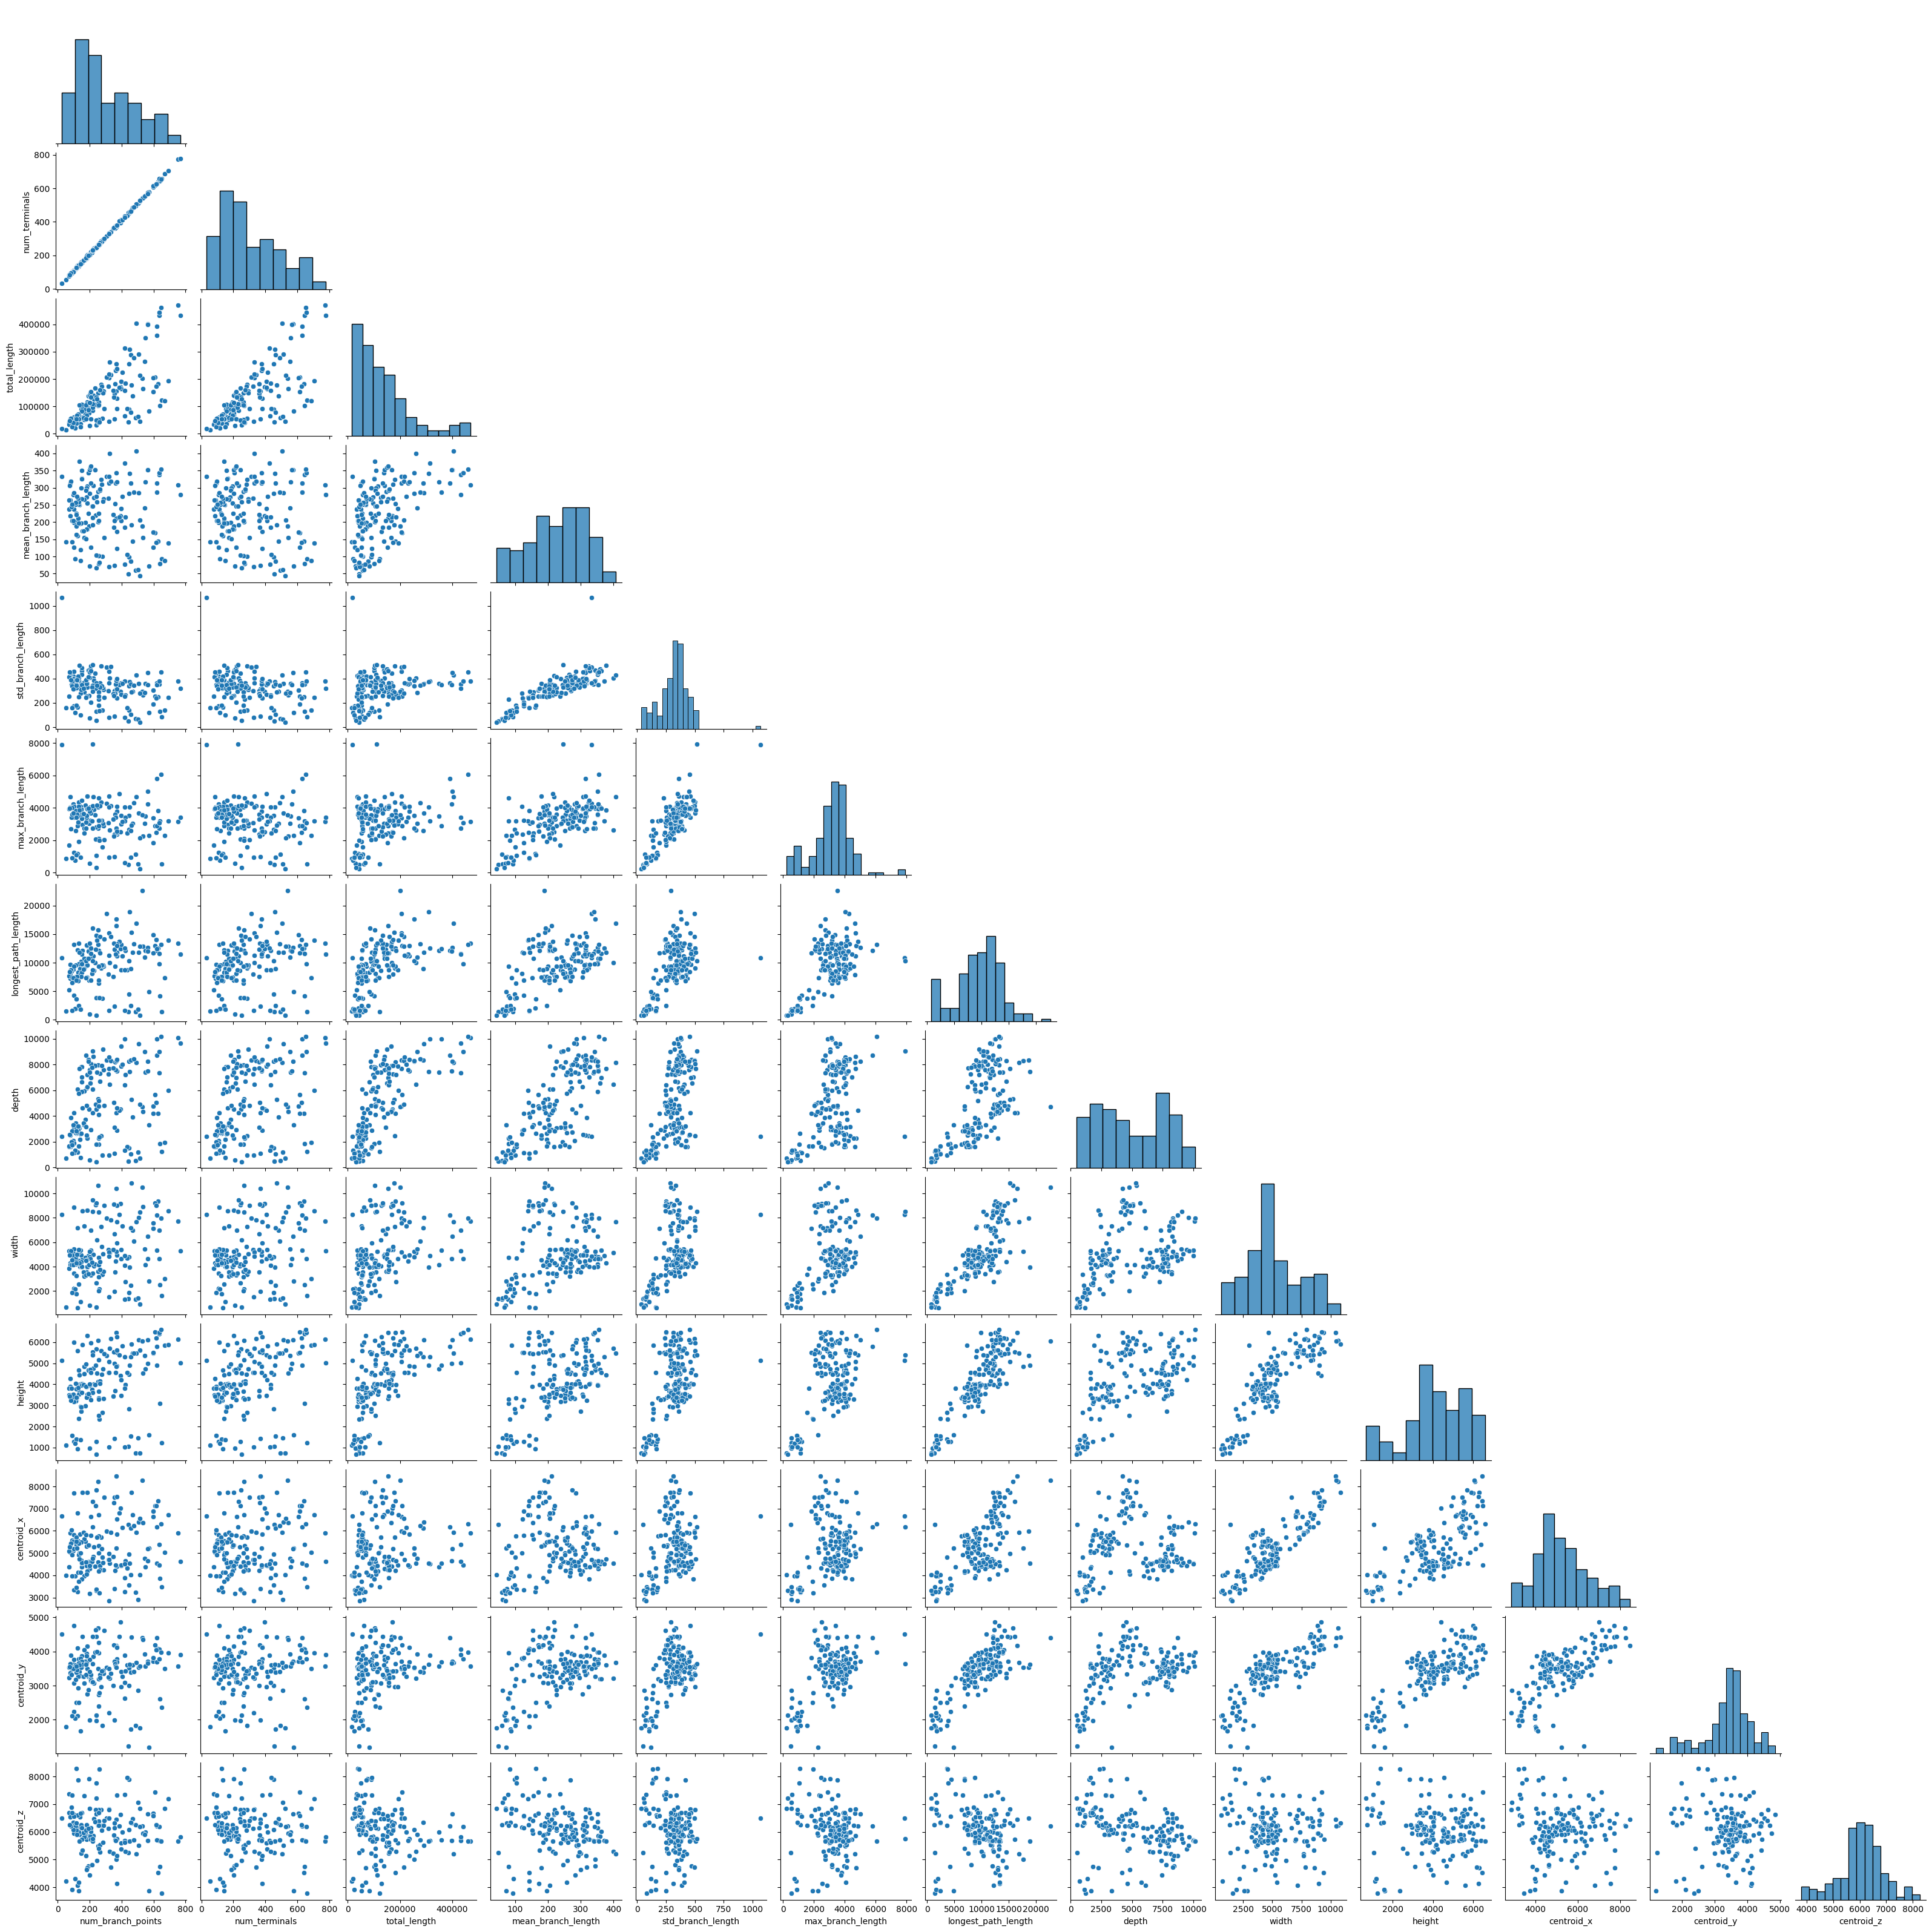

In [27]:
sns.pairplot(X, corner=True)

In [28]:
# Remove perfectly correlated feature
X = X.drop(columns=['num_terminals'])

In [29]:
from sklearn.preprocessing import StandardScaler

# remove mean and scale to unit variance
X = StandardScaler().fit_transform(X)
print(X)

[[-0.66414979 -0.3569024   0.51336175 ... -0.67666493  0.74092218
  -0.35510219]
 [ 0.42078767 -0.40898235 -1.20131223 ...  1.04556529  0.51985446
   1.50147906]
 [ 0.5394527   0.37281535 -0.10553656 ...  1.44181529  2.04749201
   0.68036731]
 ...
 [-0.21209252 -0.89029693 -1.66132762 ... -1.68351652 -0.8948913
   2.59438842]
 [-0.22339395 -0.27391457 -0.27348042 ... -0.88377104 -1.44073493
  -0.7395111 ]
 [-0.5963412  -0.45168903 -0.01925433 ...  0.0803132  -0.76190046
   0.09690213]]


/tmp/ipykernel_150/3036701009.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


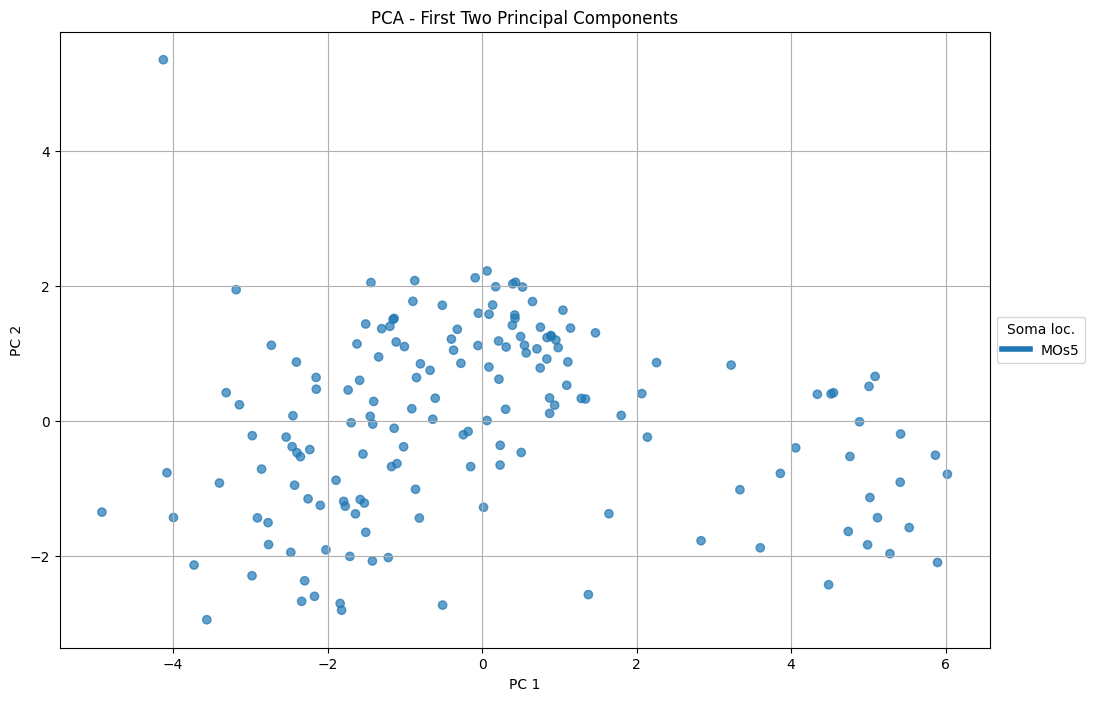

In [30]:
from sklearn.decomposition import PCA

def plot_pca(X, acronyms, n_components=2):
    p = PCA(n_components=n_components)
    transformed_data = p.fit_transform(X)

    # Map unique class labels to a range of integers
    unique_labels, label_indices = np.unique(acronyms, return_inverse=True)

    # Using a colormap that provides distinct colors
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    # Plotting the first two principal components
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], c=label_indices, cmap=cmap, alpha=0.7)

    custom_legend = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(unique_labels))]
    ax.legend(custom_legend, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Soma loc.")
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title('PCA - First Two Principal Components')
    ax.grid(True)
    plt.show()

plot_pca(X, acronyms)

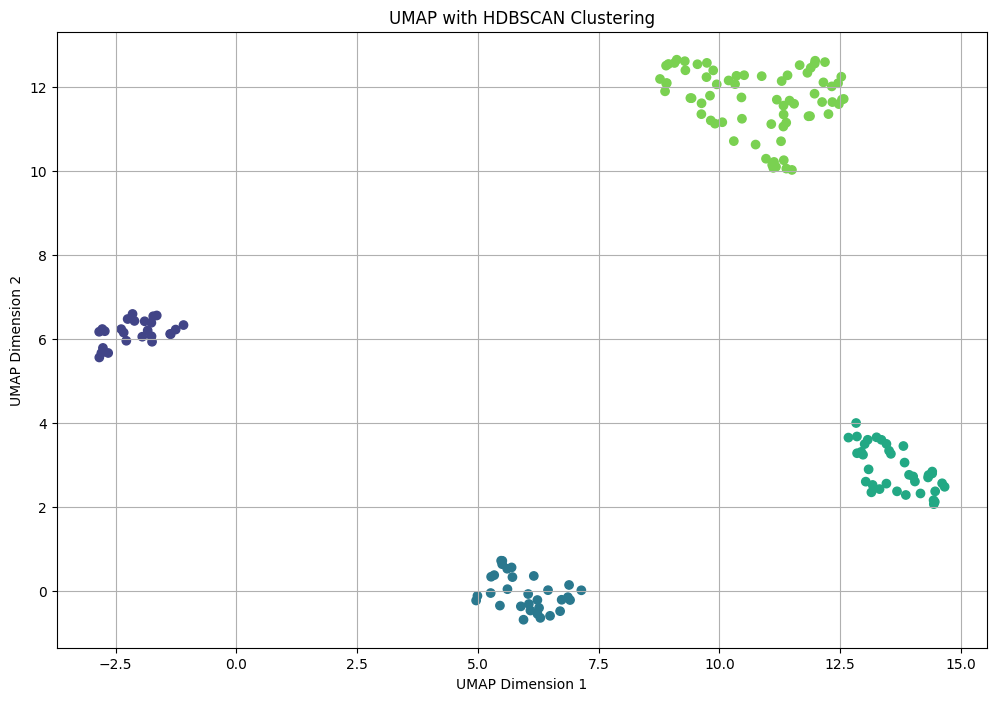

In [31]:
import umap
import hdbscan

def plot_umap(X, acronyms, n_neighbors=10, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(X)

    # Map unique class labels to a range of integers for coloring
    unique_labels, label_indices = np.unique(acronyms, return_inverse=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=label_indices, cmap=cmap, alpha=0.7)

    custom_legend = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(unique_labels))]
    ax.legend(custom_legend, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Soma loc.")

    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title('UMAP')
    ax.grid(True)

    plt.show()


def plot_umap_with_hdbscan(X, acronyms, n_neighbors=10, min_dist=0.1, n_components=2, min_cluster_size=10):
    # UMAP Reduction
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(X)

    # HDBSCAN Clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)  # Adjust min_cluster_size as needed
    clusters = clusterer.fit_predict(embedding)

    # Create a color palette with as many colors as there are unique clusters
    unique_clusters = np.unique(clusters)
    palette = sns.color_palette('viridis', len(unique_clusters))
    color_map = dict(zip(unique_clusters, palette))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=[color_map[x] for x in clusters])
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title('UMAP with HDBSCAN Clustering')
    ax.grid(True)

    plt.show()

    return clusters


cluster_labels = plot_umap_with_hdbscan(X, acronyms)

Now create an individual plot of each cluster

In [32]:
# Create a dictionary to hold graphs for each cluster
clusters = {}

# Iterate and group graphs by their cluster
for label, obj in zip(cluster_labels, graphs):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(obj)

In [33]:
for cluster in clusters.values():
    plot = k3d.plot()
    plot_graphs(cluster, plot)
    plot_ccf_mesh(acronym_to_id['root'], plot, color=rgb_to_hex(128,128,128), opacity=0.05)
    plot_ccf_mesh(acronym_to_id['MOs5'], plot, color=rgb_to_hex(0, 255, 0), opacity=0.05)
    plot.display()

Output()

Output()

Output()

Output()

## Potential questions to consider
- Do the clusters have shared projection targets? How can we find out?
- Do we get different results if computing metrics on axons and dendrites separately, then combining during clustering?
- What other metrics could be useful? How would you calculate them?
- How can we integrate brain region information into clustering?
- Do these clusters correspond to known projection classes in MOs5?